# Single target notebook

Here I explore the single target exports from the saildrone survey

In [1]:
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import warnings
from scipy import stats
from progressBar import log_progress
from matplotlib import rcParams
warnings.filterwarnings('ignore')

In [2]:
def readTargetExports(files):
    hold = []
    for filename in log_progress(files,every=1):
        df = pd.read_csv(filename, index_col=None, header=0)
        df['datetime'] = pd.to_datetime(df["Ping_date"].astype(str)+' '+df["Ping_time"])
        hold.append(df)
    df = pd.concat(hold, axis=0, ignore_index=True)
    df = df.rename(index=str, columns={"Target_longitude": "targetLon","Target_latitude": "targetLat","Target_true_depth": "targetDepth","TS_comp":"targetTS"})
    df1 = df[["datetime","targetLon","targetLat","targetDepth","targetTS"]]
    df1 = df1.set_index("datetime")
    return df1

def targetDist(df):
    fig = plt.figure(figsize=(18,4))
    plt.subplot(131)
    plt.hist(df.targetTS, bins='auto')
    plt.subplot(132)
    df['days_since'] = (df.index - min(df.index)).astype('timedelta64[D]')
    jet= plt.get_cmap('plasma')
    colors = iter(jet(np.linspace(0,1,len(df.days_since.unique()))))
    for day in np.sort(df.days_since.unique()):
        curDay = df[df.days_since == day]
        n,x  = np.histogram(curDay.targetTS, bins='auto');
        bin_centers = 0.5*(x[1:]+x[:-1])
        plt.plot(bin_centers,n, color=next(colors))


    plt.subplot(133)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df.days_since,df.targetTS)
    line = slope*df.days_since+intercept
    plt.plot(df.days_since, df.targetTS,'.')
    plt.plot(df.days_since, intercept + slope*df.days_since, 'r');
    geoffroyTS(min(line)), geoffroyTS(max(line)), geoffroyTS(np.median(line))
    
def anonTS(TS):
    length = 10**((TS+72.7)/21.8)
    return length
def geoffroyTS(TS):
    length = 10**((TS+65.13)/14.33)
    return length
def parkerstetterTS(TS):
    length = 10**((TS+60.78)/8.03)
    return length
def traynorTS(TS):
    length = 10**((TS+66)/20) #66, #68.4
    return length
def mamylovTS(TS):
    length = 10**((TS+64.3)/12.8) #66, #68.4
    return length
def brodeurTS(TS):
    length = 10**((TS+64.8)/20) #66, #68.4
    return length

## Literature TS relationships

From Anonymous:
- length = 10**((TS+72.7)/21.8)

From Geoffroy:
-  length = 10**((TS+65.13)/14.33)

From Sandi:
- length = 10**((TS+60.78)/8.03)

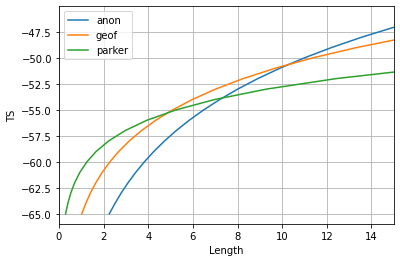

In [3]:
anon, geof, park = ([] for i in range(3))
for ts in range(-65, -45,1):
    anon.append(anonTS(ts))
    geof.append(geoffroyTS(ts))
    park.append(parkerstetterTS(ts))
plt.plot(anon, range(-65, -45,1))
plt.plot(geof, range(-65, -45,1))
plt.plot(park, range(-65, -45,1))
plt.grid()
plt.xlim([0,15])
plt.xlabel('Length')
plt.ylabel('TS');
plt.legend(['anon','geof','parker'])

Find and load in the targets that are both Sawada and frequency response filtered

In [4]:
targets1022 = glob('../../../data/EV/EVFiles/SD1022/exports/SingleTargetsNv*.csv')
df1022targets=readTargetExports(targets1022)
df1022targets['linearTS'] = 10**(df1022targets.targetTS/10)
print('There are '+str(len(df1022targets))+' targets in the 1022 dataset')

targets1023 = glob('../../../data/EV/EVFiles/SD1023/exports/SingleTargetsNv*.csv')
df1023targets=readTargetExports(targets1023)
df1023targets['linearTS'] = 10**(df1023targets.targetTS/10)
print('There are '+str(len(df1023targets))+' targets in the 1023 dataset')

There are 252755 targets in the 1022 dataset


There are 269067 targets in the 1023 dataset


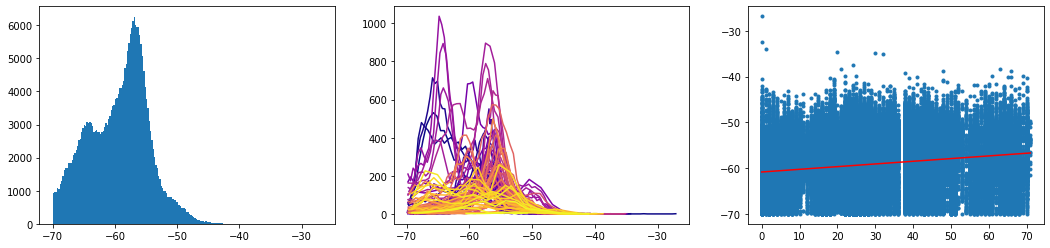

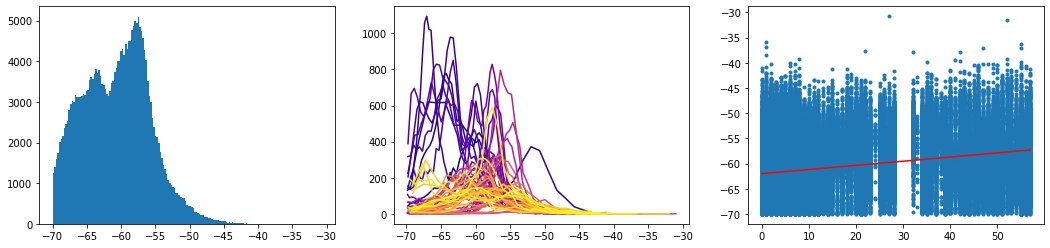

In [5]:
targetDist(df1023targets)
targetDist(df1022targets)

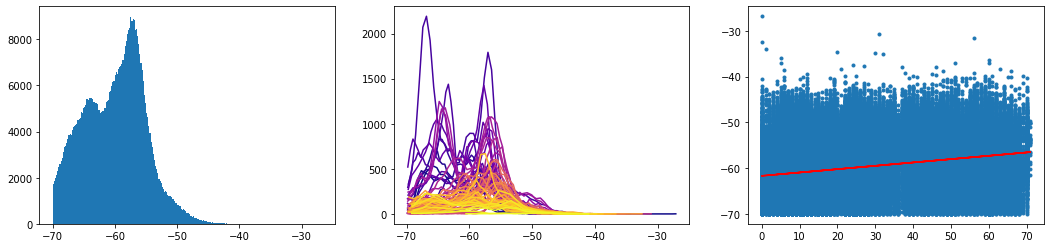

In [6]:
targetDist(pd.concat([df1022targets,df1023targets])) # targets from both 

Let's split it up by survey into survey 1 and 2, clean up 'bad' targets where there's no lat/lon values, and then also split up into the mini surveys by time.

In [5]:
dfSurvey1 = df1022targets[(df1022targets.index > '07-20-2018') & (df1022targets.index < '08-21-2018') ]
dfSurvey1.targetLon[(dfSurvey1.targetLon > 0)] = np.nan
dfSurvey1.targetLat[(dfSurvey1.targetLon > 0)] = np.nan
dfSurvey1.targetLon[(dfSurvey1.targetLat > 90)] = np.nan
dfSurvey1.targetLat[(dfSurvey1.targetLat > 90)] = np.nan
dfSurvey1.targetLon[(dfSurvey1.targetLat < -90)] = np.nan
dfSurvey1.targetLat[(dfSurvey1.targetLat < -90)] = np.nan
dfSurvey1.name = 'First Complete Survey'

df1023CS2 = df1023targets[(df1023targets.index > '08-24-2018 15:00:00') & (df1023targets.index < '09-07-2018')]
df1022CS2 = df1022targets[(df1022targets.index > '08-25-2018') & (df1022targets.index < '09-11-2018 22:00:00') ]
dfSurvey2 = pd.concat([df1023CS2, df1022CS2])
dfSurvey2.name = 'Second Complete Survey'

df1023targets.targetLon[(df1023targets.targetLon > 0)] = np.nan
df1023targets.targetLat[(df1023targets.targetLon > 0)] = np.nan
df1023targets.targetLon[(df1023targets.targetLat > 90)] = np.nan
df1023targets.targetLat[(df1023targets.targetLat > 90)] = np.nan
df1023targets.targetLon[(df1023targets.targetLat < -90)] = np.nan
df1023targets.targetLat[(df1023targets.targetLat < -90)] = np.nan

df1022targets.targetLon[(df1022targets.targetLon > 0)] = np.nan
df1022targets.targetLat[(df1022targets.targetLon > 0)] = np.nan
df1022targets.targetLon[(df1022targets.targetLat > 90)] = np.nan
df1022targets.targetLat[(df1022targets.targetLat > 90)] = np.nan
df1022targets.targetLon[(df1022targets.targetLat < -90)] = np.nan
df1022targets.targetLat[(df1022targets.targetLat < -90)] = np.nan

dfMLS1TS = df1023targets[(df1023targets.index > '07-20-2018 20:00:00') & (df1023targets.index < '08-04-2018 00:00:00')]
dfMLS1TS.name = 'MLS-1'
dfMLS2TS = df1022targets[(df1022targets.index > '07-23-2018 20:00:00') & (df1022targets.index < '08-13-2018 00:00:00')]
dfMLS2TS.name = 'MLS-2'
dfMLS3TS = pd.concat([df1023targets[(df1023targets.index > '08-13-2018 15:00:00') & (df1023targets.index < '08-16-2018 20:00:00')], df1022targets[(df1022targets.index > '08-22-2018 00:00:00') & (df1022targets.index < '08-29-2018 00:00:00')]])
dfMLS3TS.name = 'MLS-3'
dfMLS4TS = df1023targets[(df1023targets.index > '08-30-2018 20:00:00') & (df1023targets.index < '09-11-2018 17:00:00')]
dfMLS4TS.name = 'MLS-4'

In [6]:
print('There are '+str(len(dfMLS1TS))+' targets in the 1 dataset')
print('There are '+str(len(dfMLS2TS))+' targets in the 2 dataset')
print('There are '+str(len(dfMLS3TS))+' targets in the 3 dataset')
print('There are '+str(len(dfMLS4TS))+' targets in the 4 dataset')
sum([len(dfMLS1TS),len(dfMLS2TS),len(dfMLS3TS),len(dfMLS4TS)])

There are 60780 targets in the 1 dataset
There are 149740 targets in the 2 dataset
There are 27727 targets in the 3 dataset
There are 14702 targets in the 4 dataset


252949

## Look at change in the TS over the time of the 4 mini-surveys

In [30]:
means = [10*np.log10(np.mean(dfMLS1TS.linearTS)),10*np.log10(np.mean(dfMLS2TS.linearTS)),10*np.log10(np.mean(dfMLS3TS.linearTS)),10*np.log10(np.mean(dfMLS4TS.linearTS))]
medians = [10*np.log10(np.median(dfMLS1TS.linearTS)),10*np.log10(np.median(dfMLS2TS.linearTS)),10*np.log10(np.median(dfMLS3TS.linearTS)),10*np.log10(np.median(dfMLS4TS.linearTS))]
mins = [10*np.log10(np.min(dfMLS1TS.linearTS)),10*np.log10(np.min(dfMLS2TS.linearTS)),10*np.log10(np.min(dfMLS3TS.linearTS)),10*np.log10(np.min(dfMLS4TS.linearTS))]
maxs = [10*np.log10(np.max(dfMLS1TS.linearTS)),10*np.log10(np.max(dfMLS2TS.linearTS)),10*np.log10(np.max(dfMLS3TS.linearTS)),10*np.log10(np.max(dfMLS4TS.linearTS))]

[print('Mean TS:',   round(means[i],1),'Length:',round(geoffroyTS(means[i]),1), 'Median TS:',   round(medians[i],1),'Min TS:',   round(mins[i],1),'Max TS:',   round(maxs[i],1),'Length:',round(geoffroyTS(means[i]),1)) for i in range(len(means))];

Mean TS: -57.3 Length: 3.5 Median TS: -58.1 Min TS: -70.0 Max TS: -40.2 Length: 3.5
Mean TS: -58.1 Length: 3.1 Median TS: -60.0 Min TS: -70.0 Max TS: -37.7 Length: 3.1
Mean TS: -56.0 Length: 4.4 Median TS: -57.2 Min TS: -70.0 Max TS: -34.9 Length: 4.4
Mean TS: -55.7 Length: 4.5 Median TS: -57.1 Min TS: -70.0 Max TS: -38.8 Length: 4.5


In [ ]:
p1, p2 = [5,95]
10*np.log10(np.percentile(dfMLS1TS.linearTS,p1)),10*np.log10(np.percentile(dfMLS1TS.linearTS,p2))
10*np.log10(np.percentile(dfMLS2TS.linearTS,p1)),10*np.log10(np.percentile(dfMLS2TS.linearTS,p2))
10*np.log10(np.percentile(dfMLS3TS.linearTS,p1)),10*np.log10(np.percentile(dfMLS3TS.linearTS,p2))
10*np.log10(np.percentile(dfMLS4TS.linearTS,p1)),10*np.log10(np.percentile(dfMLS4TS.linearTS,p2))

In [ ]:
round(geoffroyTS(10*np.log10(np.percentile(dfMLS1TS.linearTS,p1))),1),round(geoffroyTS(10*np.log10(np.percentile(dfMLS1TS.linearTS,p2))),1)
round(geoffroyTS(10*np.log10(np.percentile(dfMLS2TS.linearTS,p1))),1),round(geoffroyTS(10*np.log10(np.percentile(dfMLS2TS.linearTS,p2))),1)
round(geoffroyTS(10*np.log10(np.percentile(dfMLS3TS.linearTS,p1))),1),round(geoffroyTS(10*np.log10(np.percentile(dfMLS3TS.linearTS,p2))),1)
round(geoffroyTS(10*np.log10(np.percentile(dfMLS4TS.linearTS,p1))),1),round(geoffroyTS(10*np.log10(np.percentile(dfMLS4TS.linearTS,p2))),1)

In [ ]:
10**(-55.7/10)/10**(-57.3/10)

In [ ]:
rcParams.update({'font.size': 15})
fig= plt.figure(figsize=(8,6), dpi=600)
ct =1
titles = ['1$^{st}$ survey','2$^{nd}$ survey','3$^{rd}$ survey','4$^{th}$ survey']
for df in [dfMLS1TS,dfMLS2TS,dfMLS3TS,dfMLS4TS]:
        n,x  = np.histogram(df.targetTS, bins='auto');
        bin_centers = 0.5*(x[1:]+x[:-1])
        plt.subplot(1,4,ct)
        plt.plot(n/sum(n),bin_centers, color='k', linewidth=1)
#        plt.plot(-1*n/sum(n),bin_centers, color='k', linewidth= .2)
        plt.fill_betweenx(bin_centers,0,n/sum(n), color = 'grey', alpha = 0.2)
        plt.axis([0, max(n/sum(n)),-70,-35])
        #plt.gca().set_xticks([])
        plt.title(titles[ct-1])
        if ct ==1:
            plt.ylabel('Target strength (dB)')
            #plt.gca().spines['right'].set_visible(False)
            #plt.gca().spines['top'].set_visible(False)
            #plt.gca().spines['bottom'].set_visible(False)
        else:
            plt.vlines(0,min(bin_centers), max(bin_centers), color='k', linewidth=1)
            plt.gca().set_yticklabels([])
            #plt.gca().set_yticks([])
            #plt.gca().axis('off')
        ct+=1
#        plt.fill_between(-1*n/sum(n),np.min(bin_centers),bin_centers, color = 'grey', alpha = 0.5))
fig.text(0.5, 0.035, 'Proportion of targets', ha='center');
#fig.text(0.2, .92,'1$^{st}$ survey',ha='center')
#fig.text(0.41, .92,'2$^{nd}$ survey',ha='center')
#fig.text(0.61, .92,'3$^{rd}$ survey',ha='center')
#fig.text(0.81, .92,'4$^{th}$ survey',ha='center')
#plt.savefig("G:/My Drive/Research/Arctic EIS II/Saildrone/manuscript/Final/figsUnfiltered/Submitted/svg/F6_2.svg")

Ok, so lets just check if we can figure out density.  The equation is p = NASC/(4)(pi)(sigmabs).  The NASC values we have from the 4 surveys come from the GLSModels notebook:
- survey 1: 197.59450
- survey 2: 197.59450 - 20.22359 = 177.37091
- survey 3: 197.59450 + 84.01316 = 281.60766
- survey 4: 197.59450 + 172.43467 = 370.02917

In [14]:
import numpy as np
def fishDens(NASC, TS):
    dens = NASC/(4*np.pi*(10**(TS/10)))
    dens = dens*(1/3429904) # convers from nmi2 to m2
    return round(dens,3)
#print('in fish per m^2',fishDens(200-26, -57.19), fishDens(161-22,-57.27), fishDens(206-29,-55.009), fishDens(358-52,-54.13))
#print('in fish per m^2',fishDens(200, -56), fishDens(161,-55.6), fishDens(206,-53.1), fishDens(358,-52.2))
#print('in fish per m^2',fishDens(200+26, -57.19), fishDens(161+22,-57.27), fishDens(206+29,-55.009), fishDens(358+52,-54.13))

#print('in fish per m^2',fishDens(200-26, means[0]), fishDens(161-22,means[1]), fishDens(206-29,means[2]), fishDens(358-52,means[3]))
#print('in fish per m^2',fishDens(200, means[0]), fishDens(161,means[1]), fishDens(206,means[2]), fishDens(358,means[3]))
#print('in fish per m^2',fishDens(200+26, means[0]), fishDens(161+22,means[1]), fishDens(206+29,means[2]), fishDens(358+52,means[3]))

print('in fish per m^2',fishDens(197-53, means[0]), fishDens(177-76,means[1]), fishDens(281-79,means[2]), fishDens(370-80,means[3]))
print('in fish per m^2',fishDens(197, means[0]), fishDens(177,means[1]), fishDens(281,means[2]), fishDens(370,means[3]))
print('in fish per m^2',fishDens(197+53, means[0]), fishDens(177+76,means[1]), fishDens(281+79,means[2]), fishDens(370+80,means[3]))

in fish per m^2 1.783 1.529 1.845 2.527
in fish per m^2 2.44 2.679 2.566 3.224
in fish per m^2 3.096 3.829 3.288 3.921


## Temporal version using set hours (24 h) USED IN MANUSCRIPT

In [7]:
pd.concat([dfMLS1TS.resample('24H').count(),dfMLS2TS.resample('24H').count(),dfMLS3TS.resample('24H').count(),dfMLS4TS.resample('24H').count()]).mean()

targetLon      3883.692308
targetLat      3883.692308
targetDepth    3891.523077
targetTS       3891.523077
linearTS       3891.523077
dtype: float64

In [8]:
df1 = dfMLS1TS.resample('24H').mean()
df2 = dfMLS2TS.resample('24H').mean()
df3 = dfMLS3TS.resample('24H').mean()
df4 = dfMLS4TS.resample('24H').mean()
julianOffset=2458118.5 

In [9]:
#pd.DataFrame({'x':x,'y':y}).to_csv('processingFiles/targets12h.csv')

In [10]:
df1.index.to_julian_date()-julianOffset

Float64Index([201.0, 202.0, 203.0, 204.0, 205.0, 206.0, 207.0, 208.0, 209.0,
              210.0, 211.0, 212.0, 213.0, 214.0, 215.0],
             dtype='float64', name='datetime')

In [11]:
x = np.concatenate([df1.index.to_julian_date()-julianOffset,
                    df2.index.to_julian_date()-julianOffset,
                    df3.index.to_julian_date()-julianOffset,
                    df4.index.to_julian_date()-julianOffset])
y = np.concatenate([df1.linearTS.values,df2.linearTS.values,df3.linearTS.values,df4.linearTS.values])
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(x[~np.isnan(y)], y[~np.isnan(y)])

Text(0.5, 0, 'Date')

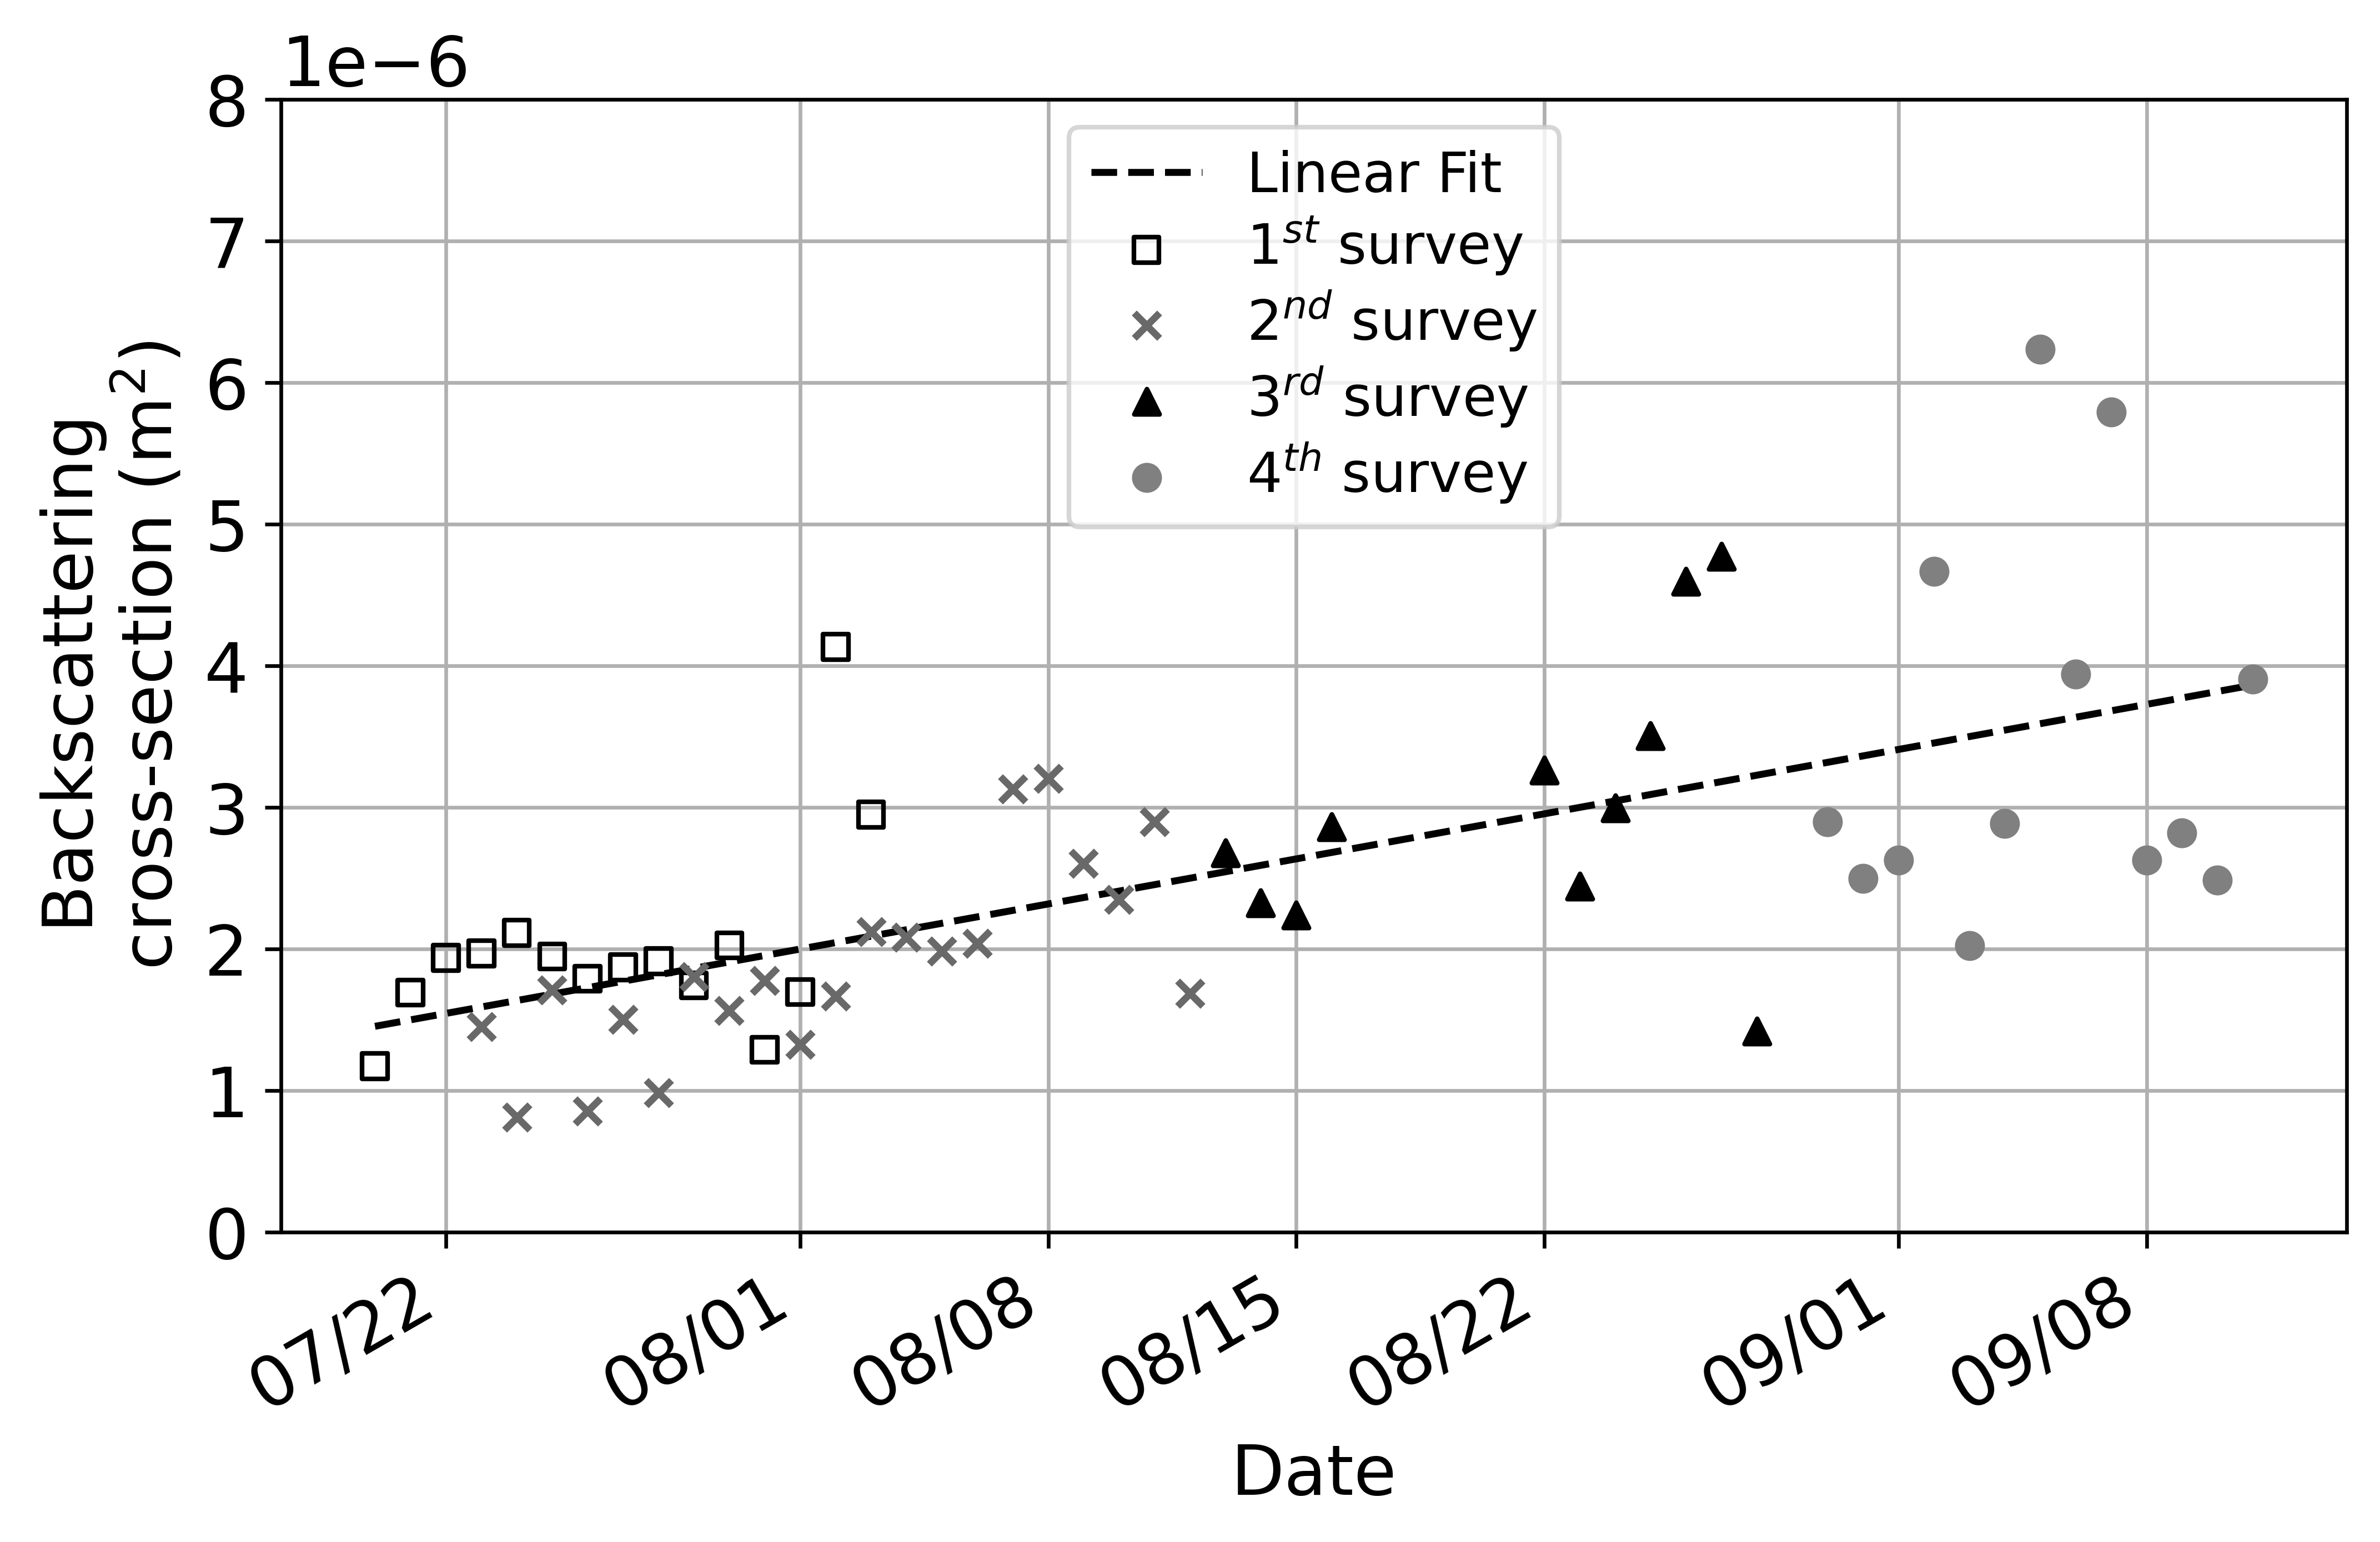

In [38]:
import datetime
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
rcParams.update({'font.size': 15})
fig= plt.figure(figsize=(8,5), dpi=600)
ax1 = plt.subplot(111)
ax1.grid(zorder=1)
ax1.scatter(df1.index.values,df1.linearTS,marker='s',color='k',facecolor='none',zorder=3,label='1$^{st}$ survey',s=30)
ax1.scatter(df2.index.values,df2.linearTS,marker='x',color='dimgrey',zorder=4,label='2$^{nd}$ survey',s=30)
ax1.scatter(df3.index.values,df3.linearTS,marker='^',color='k',zorder=5,label='3$^{rd}$ survey',s=30)
ax1.scatter(df4.index.values,df4.linearTS,marker='o',color='grey',zorder=6,label='4$^{th}$ survey',s=30)

ax1.plot((df1.index.min(),df4.index.max()),(intercept+(df1.index.min().to_julian_date()-julianOffset)*slope,intercept+(df4.index.max().to_julian_date()-julianOffset)*slope),'--k',zorder=2,label='Linear Fit')#\n(p<0.001, r$^{2}$='+str(round(r_value**2,2))+')'

ax1.set_ylim([0,.8e-5])
fig.autofmt_xdate()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.legend(ncol=1,loc=9,labelspacing=.2,fontsize=12)#['','','Linear Fit (p<.001, r$^{2}$=.34)','1$^{st}$ survey','2$^{nd}$ survey','3$^{rd}$ survey','4$^{th}$ survey'])
ax1.set_ylabel('Backscattering\n cross-section (m$^{2}$)')
ax1.set_xlabel('Date')

In [13]:
10*np.log10(std_err)

-81.71815491230285

In [15]:
midDay = [(df1.index.min().to_julian_date()-julianOffset)+((df1.index.max().to_julian_date()-julianOffset)-(df1.index.min().to_julian_date()-julianOffset))/2,
          (df2.index.min().to_julian_date()-julianOffset)+((df2.index.max().to_julian_date()-julianOffset)-(df2.index.min().to_julian_date()-julianOffset))/2,
          (df3.index.min().to_julian_date()-julianOffset)+((df3.index.max().to_julian_date()-julianOffset)-(df3.index.min().to_julian_date()-julianOffset))/2,
          (df4.index.min().to_julian_date()-julianOffset)+((df4.index.max().to_julian_date()-julianOffset)-(df4.index.min().to_julian_date()-julianOffset))/2]

lows = [10*np.log10((intercept+midDay[0]*(slope-std_err))),
        10*np.log10((intercept+midDay[1]*(slope-std_err))),
        10*np.log10((intercept+midDay[2]*(slope-std_err))),
        10*np.log10((intercept+midDay[3]*(slope-std_err)))]

means = [10*np.log10((intercept+midDay[0]*(slope))),
        10*np.log10((intercept+midDay[1]*(slope))),
        10*np.log10((intercept+midDay[2]*(slope))),
        10*np.log10((intercept+midDay[3]*(slope)))]

highs = [10*np.log10((intercept+midDay[0]*(slope+std_err))),
        10*np.log10((intercept+midDay[1]*(slope+std_err))),
        10*np.log10((intercept+midDay[2]*(slope+std_err))),
        10*np.log10((intercept+midDay[3]*(slope+std_err)))]

print(lows)
print(means)
print(highs)

[-64.27595365769102, -62.17492668542535, -58.78515547854323, -57.159603984816634]
[-57.51050216397023, -56.88918129125308, -55.39386876543893, -54.445478091578686]
[-54.98342369556664, -54.57471776379634, -53.5130424059644, -52.78795534120733]


In [78]:
print('Geoffroy')
print([geoffroyTS(x) for x in lows])
print([geoffroyTS(x) for x in means])
print([geoffroyTS(x) for x in highs])
print((geoffroyTS(means[3])-geoffroyTS(means[0]))/(df4.index.max().to_julian_date()-df1.index.min().to_julian_date()))
print((geoffroyTS(10*np.log10(intercept+(df4.index.max().to_julian_date()-julianOffset)*slope))-geoffroyTS(10*np.log10(intercept+(df1.index.min().to_julian_date()-julianOffset)*slope)))/(df4.index.max().to_julian_date()-df1.index.min().to_julian_date()))

Geoffroy
[1.1470926278621318, 1.6077401697544167, 2.7718296765777404, 3.5991793649822976]
[3.401860709516569, 3.7590194981557636, 4.779945833447246, 5.566794091333776]
[5.1058181023764515, 5.452382797171644, 6.4665693929424535, 7.265628351862282]
0.04084779965692843
0.05462616111457006


In [83]:
print('traynor')
print([traynorTS(x) for x in lows])
print([traynorTS(x) for x in means])
print([traynorTS(x) for x in highs])
print((traynorTS(means[3])-traynorTS(means[0]))/(df4.index.max().to_julian_date()-df1.index.min().to_julian_date()))
print((traynorTS(10*np.log10(intercept+(df4.index.max().to_julian_date()-julianOffset)*slope))-traynorTS(10*np.log10(intercept+(df1.index.min().to_julian_date()-julianOffset)*slope)))/(df4.index.max().to_julian_date()-df1.index.min().to_julian_date()))

traynor
[1.2195576004156665, 1.553294003769872, 2.294786181727225, 2.76706780127215]
[2.65750990446356, 2.8545715653941297, 3.3908342540340377, 3.7820398054339788]
[3.5549116787780015, 3.7261824139145365, 4.210637749416936, 4.577224700944564]
0.021217545301328654
0.028598356869134835


In [79]:
print('anon')
print([anonTS(x) for x in lows])
print([anonTS(x) for x in means])
print([anonTS(x) for x in highs])
print((anonTS(means[3])-anonTS(means[0]))/(df4.index.max().to_julian_date()-df1.index.min().to_julian_date()))
print((anonTS(10*np.log10(intercept+(df4.index.max().to_julian_date()-julianOffset)*slope))-anonTS(10*np.log10(intercept+(df1.index.min().to_julian_date()-julianOffset)*slope)))/(df4.index.max().to_julian_date()-df1.index.min().to_julian_date()))

anon
[2.4345805278607764, 3.039495664101168, 4.3480609196147, 5.162525413090525]
[4.974689233779287, 5.312108210293679, 6.220986099642514, 6.876435762365247]
[6.496612844604992, 6.783205352701596, 7.588145844414558, 8.192124501868488]
0.03588200997332
0.04845234112431561


In [80]:
print('parkerstetter')
print([parkerstetterTS(x) for x in lows])
print([parkerstetterTS(x) for x in means])
print([parkerstetterTS(x) for x in highs])
print((parkerstetterTS(means[3])-parkerstetterTS(means[0]))/(df4.index.max().to_julian_date()-df1.index.min().to_julian_date()))
print((parkerstetterTS(10*np.log10(intercept+(df4.index.max().to_julian_date()-julianOffset)*slope))-parkerstetterTS(10*np.log10(intercept+(df1.index.min().to_julian_date()-julianOffset)*slope)))/(df4.index.max().to_julian_date()-df1.index.min().to_julian_date()))

parkerstetter
[0.36697662208369997, 0.6703252724086846, 1.7718378517474431, 2.823961564552229]
[2.553644148972093, 3.051654279871284, 4.685447626525582, 6.149743819597917]
[5.270660515911963, 5.926010551844826, 8.034817912707888, 9.891754004066893]
0.06785093718161932
0.08944252004581106


In [81]:
print('mamylovTS')
print([mamylovTS(x) for x in lows])
print([mamylovTS(x) for x in means])
print([mamylovTS(x) for x in highs])
print((mamylovTS(means[3])-mamylovTS(means[0]))/(df4.index.max().to_julian_date()-df1.index.min().to_julian_date()))
print((mamylovTS(10*np.log10(intercept+(df4.index.max().to_julian_date()-julianOffset)*slope))-mamylovTS(10*np.log10(intercept+(df1.index.min().to_julian_date()-julianOffset)*slope)))/(df4.index.max().to_julian_date()-df1.index.min().to_julian_date()))

mamylovTS
[1.0043350528160064, 1.4656198984553035, 2.696790615591294, 3.6127959940218357]
[3.3917943971457976, 3.7928896854574794, 4.963539732487615, 5.886871067062384]
[5.343890170459973, 5.751586752016975, 6.961952599059612, 7.931922988586527]
0.04707691830031296
0.0627752027526873


In [65]:
(df4.index.max().to_julian_date()-df1.index.min().to_julian_date())

53.0

In [82]:
print('brodeur')
print([brodeurTS(x) for x in lows])
print([brodeurTS(x) for x in means])
print([brodeurTS(x) for x in highs])
print((brodeurTS(means[3])-brodeurTS(means[0]))/(df4.index.max().to_julian_date()-df1.index.min().to_julian_date()))
print((brodeurTS(10*np.log10(intercept+(df4.index.max().to_julian_date()-julianOffset)*slope))-brodeurTS(10*np.log10(intercept+(df1.index.min().to_julian_date()-julianOffset)*slope)))/(df4.index.max().to_julian_date()-df1.index.min().to_julian_date()))

brodeur
[1.0621902658162519, 1.352862521780661, 1.99867521101875, 2.4100153058478693]
[2.314594366735422, 2.4862278983822192, 2.953293174839533, 3.2940189662975743]
[3.096198637725285, 3.245369212054218, 3.6673121702367646, 3.9865960575703245]
0.018479709425700985
0.024908127565586805


In [16]:
import numpy as np
def fishDens(NASC, TS):
    dens = NASC/(4*np.pi*(10**(TS/10)))
    dens = dens*(1/3429904) # convers from nmi2 to m2
    return round(dens,3)

print('in fish per m^2',fishDens(197-53, means[0]), fishDens(177-76,means[1]), fishDens(281-79,means[2]), fishDens(369-80,means[3]))
print('in fish per m^2',fishDens(197, means[0]), fishDens(177,means[1]), fishDens(281,means[2]), fishDens(370,means[3]))
print('in fish per m^2',fishDens(197+53, means[0]), fishDens(177+76,means[1]), fishDens(281+79,means[2]), fishDens(369+80,means[3]))

in fish per m^2 1.883 1.145 1.623 1.866
in fish per m^2 2.576 2.006 2.257 2.389
in fish per m^2 3.27 2.868 2.892 2.899


## Gridded Version

In [46]:
def fastGridTargets(data):
    lats = np.arange(64.75, 72.5, 0.5)
    lons = np.arange(-170, -157.5, 0.5)
    ts = []
    latC = []
    lonC = []
    day = []
    for curlat in lats:
        for curlon in lons:
            curPoints = data[(data.targetLat > curlat) & (data.targetLat < curlat+.5) & 
                                  (data.targetLon > curlon) & (data.targetLon < curlon+.5)]
            if len(curPoints) > 0:
                ts.append(np.nanmean(curPoints.linearTS))
                latC.append(curlat+.25)
                lonC.append(curlon+.25)
                day.append(curPoints.index.date[0])
    df = pd.DataFrame({'ts':ts, 'latC':latC,'lonC': lonC,'date':pd.to_datetime(day)})
    df.name = data.name
    return df

#dfs = [dfMLS1Grid, dfMLS2Grid, dfMLS3Grid, dfMLS4Grid]
#dfOverlapMLS = reduce(lambda left,right: pd.merge(left,right,on=['latC','lonC']), dfs)

In [50]:
from functools import reduce
df1 = fastGridTargets(dfMLS1TS)
df2 = fastGridTargets(dfMLS2TS)
df3 = fastGridTargets(dfMLS3TS)
df4 = fastGridTargets(dfMLS4TS)
dfs = [df1, df2]
dfOverlapMLSTS = reduce(lambda left,right: pd.merge(left,right,on=['latC','lonC'],suffixes=('1','2')), dfs)
dfs = [dfOverlapMLSTS,df3,df4]
dfOverlapMLSTS = reduce(lambda left,right: pd.merge(left,right,on=['latC','lonC'],suffixes=('3','4')), dfs)

In [51]:
x = np.concatenate([dfOverlapMLSTS.date1.dt.dayofyear.values,dfOverlapMLSTS.date2.dt.dayofyear.values,dfOverlapMLSTS.date3.dt.dayofyear.values,dfOverlapMLSTS.date4.dt.dayofyear.values])
y = np.concatenate([dfOverlapMLSTS.ts1.values,dfOverlapMLSTS.ts2.values,dfOverlapMLSTS.ts3.values,dfOverlapMLSTS.ts4.values])
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

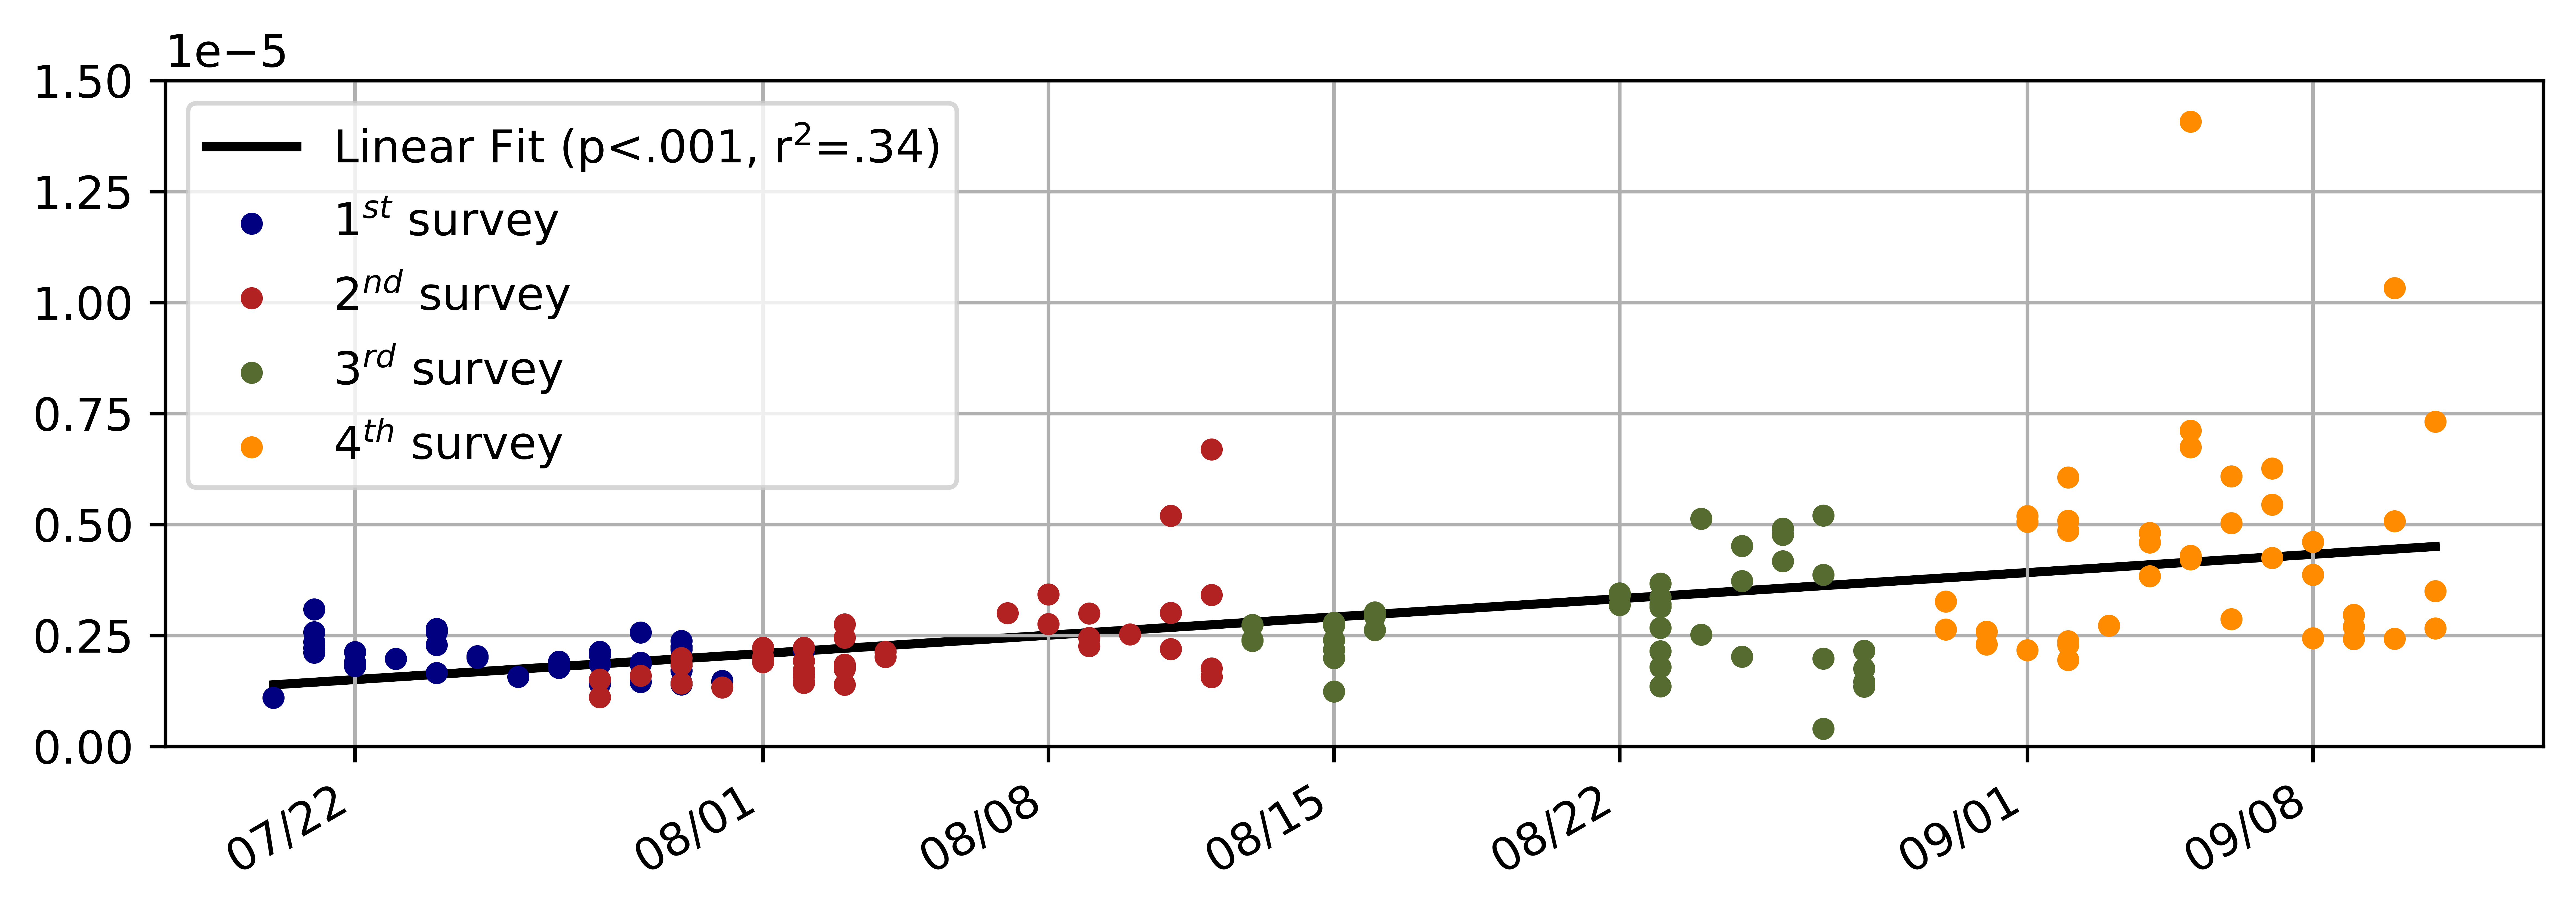

In [52]:
import datetime
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates

fig = plt.figure(figsize=(9.4,3),dpi=1200)
rcParams['lines.linewidth'] = 2
rcParams['font.size']=10
ax1 = plt.subplot(111)
ax1.scatter(dfOverlapMLSTS.date1,dfOverlapMLSTS.ts1,color='navy',zorder=2,label='1$^{st}$ survey',s=15)
ax1.scatter(dfOverlapMLSTS.date2,dfOverlapMLSTS.ts2,color='firebrick',zorder=3,label='2$^{nd}$ survey',s=15)
ax1.scatter(dfOverlapMLSTS.date3,dfOverlapMLSTS.ts3,color='darkolivegreen',zorder=4,label='3$^{rd}$ survey',s=15)
ax1.scatter(dfOverlapMLSTS.date4,dfOverlapMLSTS.ts4,color='darkorange',zorder=5,label='4$^{th}$ survey',s=15)

#ax1.text(dfOverlapMLSTS.date1.min()+datetime.timedelta(days=5),1.22,'1$^{st}$ survey')
#ax1.text(dfOverlapMLSTS.date2.min()+datetime.timedelta(days=6),1.02,'2$^{nd}$ survey')
#ax1.text(dfOverlapMLSTS.date3.min()+datetime.timedelta(days=5),1.22,'3$^{rd}$ survey')
#ax1.text(dfOverlapMLSTS.date4.min()+datetime.timedelta(days=4),1.22,'4$^{th}$ survey')
# Add the boxes for the surveys
#rect =Rectangle((dfOverlapMLSTS.date1.min(),0),dfOverlapMLSTS.date1.max()-dfOverlapMLSTS.date1.min(),1.5,edgecolor='None',facecolor="dimgray", alpha=0.2)
#ax1.add_patch(rect)
#rect =Rectangle((dfOverlapMLSTS.date2.min(),0),dfOverlapMLSTS.date2.max()-dfOverlapMLSTS.date2.min(),1.5,edgecolor='None',facecolor="silver",alpha=0.3)
#ax1.add_patch(rect)
#rect =Rectangle((dfOverlapMLSTS.date3.min(),0),dfOverlapMLSTS.date3.max()-dfOverlapMLSTS.date3.min(),1.5,edgecolor='None',facecolor="gray",alpha=0.2)
#ax1.add_patch(rect)
#rect =Rectangle((dfOverlapMLSTS.date4.min(),0),dfOverlapMLSTS.date4.max()-dfOverlapMLSTS.date4.min(),1.5,edgecolor='None',facecolor="lightgray",alpha=0.35)
#ax1.add_patch(rect)

#ax1.plot([dfOverlapMLSTS.date1.min(),dfOverlapMLSTS.date1.max()],[1.2,1.2],color='k',linewidth=1,marker='|')
#ax1.plot([dfOverlapMLSTS.date2.min(),dfOverlapMLSTS.date2.max()],[1.15,1.15],color='k',linewidth=1,marker='|')
#ax1.plot([dfOverlapMLSTS.date3.min(),dfOverlapMLSTS.date3.max()],[1.2,1.2],color='k',linewidth=1,marker='|')
#ax1.plot([dfOverlapMLSTS.date4.min(),dfOverlapMLSTS.date4.max()],[1.2,1.2],color='k',linewidth=1,marker='|')
#ax1.set_xlim([dfOverlapMLSTS.date1.min()-datetime.timedelta(days=1),dfOverlapMLSTS.date4.max()+datetime.timedelta(days=1)])
#ax1.plot((dfOverlapMLSTS.date1.min(),dfOverlapMLSTS.date4.max()),(intercept+201*(slope+std_err),intercept+254*(slope+std_err)),'--k',zorder=1)
#ax1.plot((dfOverlapMLSTS.date1.min(),dfOverlapMLSTS.date4.max()),(intercept+201*(slope-std_err),intercept+254*(slope-std_err)),'--k',zorder=1)
ax1.plot((dfOverlapMLSTS.date1.min(),dfOverlapMLSTS.date4.max()),(intercept+201*slope,intercept+254*slope),'-k',zorder=1,label='Linear Fit (p<.001, r$^{2}$=.34)')

ax1.set_ylim([0,1.5e-5])
fig.autofmt_xdate()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax1.grid(zorder=0)
plt.legend()#['','','Linear Fit (p<.001, r$^{2}$=.34)','1$^{st}$ survey','2$^{nd}$ survey','3$^{rd}$ survey','4$^{th}$ survey'])

In [53]:
midDay = [dfOverlapMLSTS.date1.dt.dayofyear.min()+(dfOverlapMLSTS.date1.dt.dayofyear.max()-dfOverlapMLSTS.date1.dt.dayofyear.min())/2,
          dfOverlapMLSTS.date2.dt.dayofyear.min()+(dfOverlapMLSTS.date2.dt.dayofyear.max()-dfOverlapMLSTS.date2.dt.dayofyear.min())/2,
          dfOverlapMLSTS.date3.dt.dayofyear.min()+(dfOverlapMLSTS.date3.dt.dayofyear.max()-dfOverlapMLSTS.date3.dt.dayofyear.min())/2,
          dfOverlapMLSTS.date4.dt.dayofyear.min()+(dfOverlapMLSTS.date4.dt.dayofyear.max()-dfOverlapMLSTS.date4.dt.dayofyear.min())/2]

lows = [10*np.log10((intercept+midDay[0]*(slope-std_err))),
        10*np.log10((intercept+midDay[1]*(slope-std_err))),
        10*np.log10((intercept+midDay[2]*(slope-std_err))),
        10*np.log10((intercept+midDay[3]*(slope-std_err)))]

means = [10*np.log10((intercept+midDay[0]*(slope))),
        10*np.log10((intercept+midDay[1]*(slope))),
        10*np.log10((intercept+midDay[2]*(slope))),
        10*np.log10((intercept+midDay[3]*(slope)))]

highs = [10*np.log10((intercept+midDay[0]*(slope+std_err))),
        10*np.log10((intercept+midDay[1]*(slope+std_err))),
        10*np.log10((intercept+midDay[2]*(slope+std_err))),
        10*np.log10((intercept+midDay[3]*(slope+std_err)))]

In [33]:
((intercept+midDay[3]*(slope))- (intercept+midDay[0]*(slope)))/(intercept+midDay[0]*(slope))

0.9991328451745131

In [61]:
print(lows)
print(means)
print(highs)

print([geoffroyTS(x) for x in lows])
print([geoffroyTS(x) for x in means])
print([geoffroyTS(x) for x in highs])

(geoffroyTS(10*np.log10(intercept+(dfOverlapMLSTS.date4.dt.dayofyear.max())*slope))-geoffroyTS(10*np.log10(intercept+(dfOverlapMLSTS.date1.dt.dayofyear.min())*slope)))/(dfOverlapMLSTS.date4.dt.dayofyear.max()-dfOverlapMLSTS.date1.dt.dayofyear.min())

[-64.80832286056761, -60.98446371874182, -57.886593486359246, -56.14295951759456]
[-57.523871435222105, -56.38728962439206, -54.89707588584964, -53.82029523000724]
[-54.939597737602874, -54.20446267510268, -53.14311290626812, -52.315121470861634]
[1.0530471365790828, 1.9466628387583977, 3.2023698945843115, 4.237880174040973]
[3.394560633784921, 4.074726100709877, 5.177153071879776, 6.15506597609459]
[5.141900577458939, 5.786608465358617, 6.862604658221033, 7.839155192956061]


0.06889396911684419

In [507]:
import numpy as np
def fishDens(NASC, TS):
    dens = NASC/(4*np.pi*(10**(TS/10)))
    dens = dens*(1/3429904) # convers from nmi2 to m2
    return round(dens,3)

print('in fish per m^2',fishDens(197-53, means[0]), fishDens(177-76,means[1]), fishDens(281-79,means[2]), fishDens(369-80,means[3]))
print('in fish per m^2',fishDens(197, means[0]), fishDens(177,means[1]), fishDens(281,means[2]), fishDens(370,means[3]))
print('in fish per m^2',fishDens(197+53, means[0]), fishDens(177+76,means[1]), fishDens(281+79,means[2]), fishDens(369+80,means[3]))

in fish per m^2 1.889 1.02 1.447 1.616
in fish per m^2 2.584 1.787 2.013 2.069
in fish per m^2 3.28 2.555 2.579 2.511


### With results from GLS form

These are the values from the R model (see GLSModels.ipynb). I included them here for comparison, but used the simpler linear regression above due to the lack of apparent autocorrelation of the residuals in the linear model.

In [365]:
intercept = -8.508546e-06
slope = 5.023700e-08
std_err = 1.150490e-08

In [366]:
midDay = [(df1.index.min().to_julian_date()-2458118.5)+((df1.index.max().to_julian_date()-2458118.5)-(df1.index.min().to_julian_date()-2458118.5))/2,
          (df2.index.min().to_julian_date()-2458118.5)+((df2.index.max().to_julian_date()-2458118.5)-(df2.index.min().to_julian_date()-2458118.5))/2,
          (df3.index.min().to_julian_date()-2458118.5)+((df3.index.max().to_julian_date()-2458118.5)-(df3.index.min().to_julian_date()-2458118.5))/2,
          (df4.index.min().to_julian_date()-2458118.5)+((df4.index.max().to_julian_date()-2458118.5)-(df4.index.min().to_julian_date()-2458118.5))/2]

lows = [10*np.log10((intercept+midDay[0]*(slope-std_err))),
        10*np.log10((intercept+midDay[1]*(slope-std_err))),
        10*np.log10((intercept+midDay[2]*(slope-std_err))),
        10*np.log10((intercept+midDay[3]*(slope-std_err)))]

means = [10*np.log10((intercept+midDay[0]*(slope))),
        10*np.log10((intercept+midDay[1]*(slope))),
        10*np.log10((intercept+midDay[2]*(slope))),
        10*np.log10((intercept+midDay[3]*(slope)))]

highs = [10*np.log10((intercept+midDay[0]*(slope+std_err))),
        10*np.log10((intercept+midDay[1]*(slope+std_err))),
        10*np.log10((intercept+midDay[2]*(slope+std_err))),
        10*np.log10((intercept+midDay[3]*(slope+std_err)))]

print(lows)
print(means)
print(highs)

print([geoffroyTS(x) for x in lows])
print([geoffroyTS(x) for x in means])
print([geoffroyTS(x) for x in highs])

[nan, nan, -62.832666428682, -59.50308248930392]
[-57.03679805063989, -56.42093773567989, -54.94449213771926, -53.99939304530166]
[-53.585183910400424, -53.23258206932476, -52.30250991448845, -51.648147791544915]
[nan, nan, 1.4464931096981095, 2.4698294123101796]
[3.6709066367419436, 4.052754834009886, 5.137858339464592, 5.980460269460005]
[6.392042345236063, 6.764652535881714, 7.855057039598264, 8.725958312999317]
